# Identify interactions between odor and W_AIR representations in G4

In [1]:
%matplotlib inline
from copy import deepcopy
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from aux import Generic
from data import DataLoader, random_chunk_split
from db import make_session, d_models
from lin_fit import fit_h_train_test, calc_r2
from plot import set_font_size, unity_line

import CONFIG as C

In [2]:
TRAIN_LEN = 32  # s
TEST_LEN = 8  # s

EXPTS = ['white_odor_fluct']

WDW = (-3, 1)

METHOD = 'built-in'
PARAMS = {
    'odor_binary': {'model': LinearRegression},
    'w_air': {'model': lambda: Lasso(alpha=0.5)},
    'air': {'model': LinearRegression},
}

Linear models

In [3]:
class ModelOS(object):
    
    name = 'OS'
    
    def __init__(self, trial):
        
        # run odor_binary --> g4s fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary'],
            y_name='g4s',
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=True,
            C=C)

In [4]:
class ModelOR(object):
    
    name = 'OR'
    
    def __init__(self, trial):
        
        # run odor_binary --> g4r fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary'],
            y_name='g4r',
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=True,
            C=C)

In [5]:
class ModelOL(object):
    
    name = 'OL'
    
    def __init__(self, trial):
        
        # run odor_binary --> g4l fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary'],
            y_name='g4l',
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=True,
            C=C)

In [6]:
class ModelW(object):
    
    name = 'W'
    
    def __init__(self, trial):
        
        # run w_air --> g4d fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['w_air'],
            y_name='g4d',
            wdws={'w_air': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['w_air'],
            normed=False,
            C=C)

In [7]:
class ModelA(object):
    
    name = 'A'
    
    def __init__(self, trial):
        
        # run air --> g4d fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['air'],
            y_name='g4d',
            wdws={'air': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['air'],
            normed=False,
            C=C)

### Plot truth vs predicted G4X for each trial/model

In [8]:
# load trials
session = make_session()
trials = session.query(d_models.Trial).filter(
    d_models.Trial.expt.in_(EXPTS)).all()
session.close()

# load data and create a moving average 
for trial in trials:
    trial.dl = DataLoader(trial, 0, None)

In [9]:
MODEL_CLASSES = [ModelOS, ModelOR, ModelOL, ModelW, ModelA]

# fit models
models = {}

for model_class in MODEL_CLASSES:
    
    models_ = {trial.name: model_class(trial) for trial in trials}
    models[model_class.name] = models_

In [10]:
AX_GRID = (len(trials), len(models))
AX_H = 3.5
FIG_SIZE = (16, AX_H*AX_GRID[0])

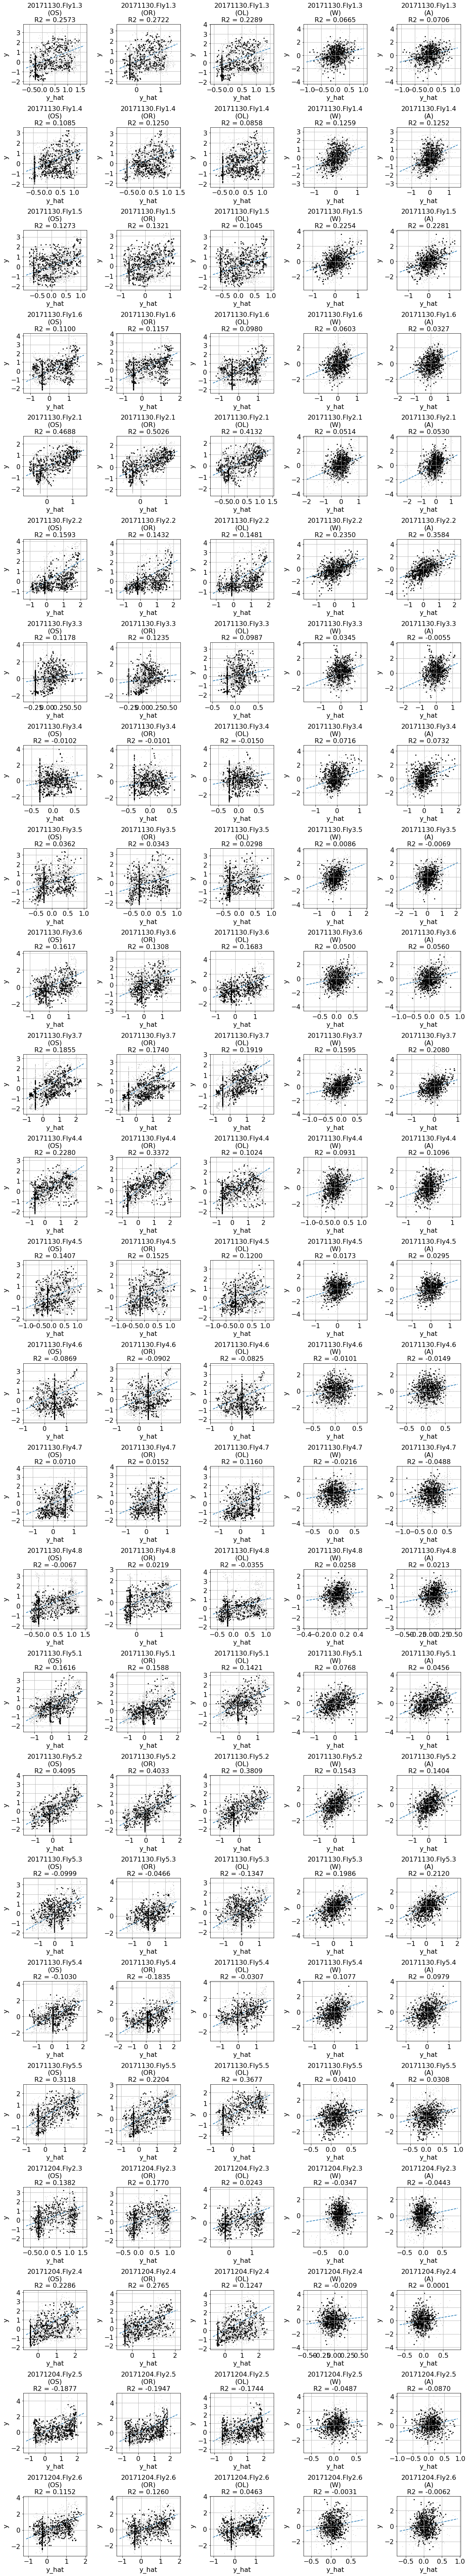

In [11]:
fig, axs = plt.subplots(*AX_GRID, figsize=FIG_SIZE, tight_layout=True)

for trial, ax_row in zip(trials, axs):
    for model_class, ax in zip(MODEL_CLASSES, ax_row):
        
        model = models[model_class.name][trial.name]
            
        y = model.rslt.y
        y_hat_train = model.rslt.y_hat_train
        y_hat_test = model.rslt.y_hat_test
        r2_test = model.rslt.r2_test
            
        ax.scatter(y_hat_train, y, lw=0, c='gray', s=1)
        ax.scatter(y_hat_test, y, lw=0, c='k', s=8)
        
        unity_line(ax, *ax.get_xlim(), ls='--', zorder=-1)
        
        ax.grid()

        ax.set_title('{0}\n({1})\nR2 = {2:.4f}'.format(trial.name, model.name, r2_test))
            
for ax in axs.flatten():
    ax.set_xlabel('y_hat')
    ax.set_ylabel('y')
    set_font_size(ax, 16)

### Make bar chart of R2 values

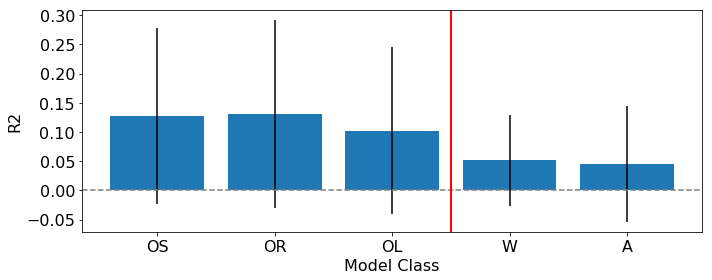

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

r2_mdns = []
r2_stds = []

for model_class in MODEL_CLASSES:
    
    r2s = []
    
    for trial in trials:
        model = models[model_class.name][trial.name]
        
        r2 = model.rslt.r2_test
            
        r2s.append(r2)
        
    r2_mdns.append(np.nanmedian(r2s))
    r2_stds.append(np.nanstd(r2s))
    
x_bar = np.arange(len(r2_mdns))
x_ticks = x_bar
x_tick_labels = [model_class.name for model_class in MODEL_CLASSES]

ax.bar(x_bar, r2_mdns, yerr=r2_stds, align='center')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

ax.axhline(0, color='gray', ls='--')
ax.axvline(2.5, color='r', lw=2)

ax.set_xlabel('Model Class')
ax.set_ylabel('R2')

set_font_size(ax, 16)

### Show filters

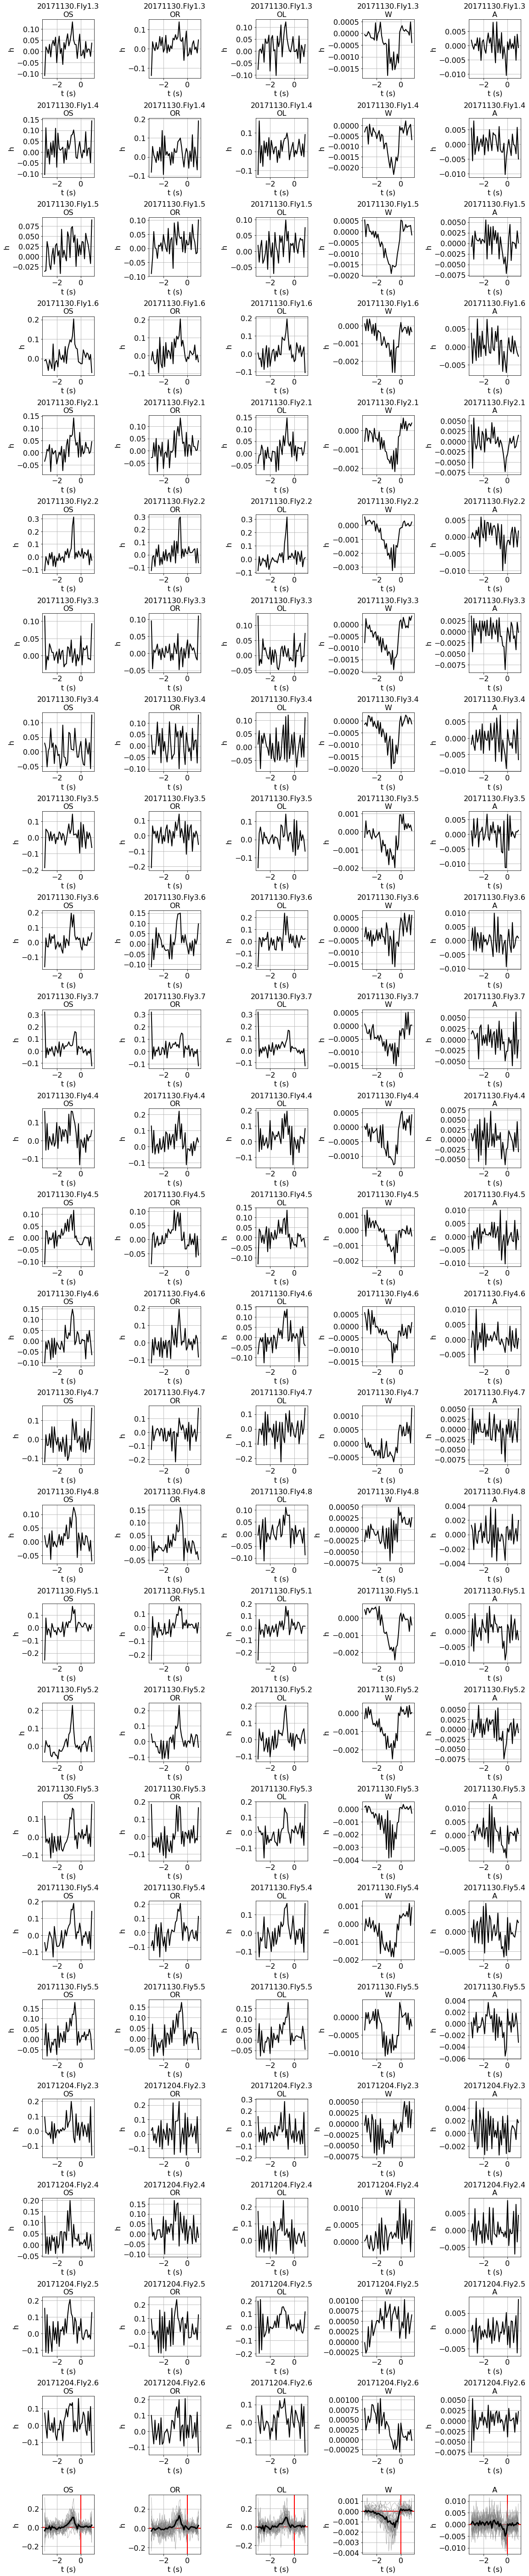

In [15]:
AX_GRID = (len(trials) + 1, len(models))
AX_H = 3
FIG_SIZE = (16, AX_H*AX_GRID[0])

fig, axs = plt.subplots(*AX_GRID, figsize=FIG_SIZE, tight_layout=True)

labels = [mc.name for mc in MODEL_CLASSES]

t_hs = {label: [] for label in labels}
hs = {label: [] for label in labels}

# plot individual trial filters
for trial, ax_row in zip(trials, axs):
    for ctr, ax in enumerate(ax_row):
        
        label = labels[ctr]
        model = models[label][trial.name]
        t_h = model.rslt.t_hs[model.rslt.x_names[0]]
        h = model.rslt.hs[model.rslt.x_names[0]]
            
        ax.plot(t_h, h, lw=2, c='k')
        ax.set_title('{}\n{}'.format(trial.name, label))
        
        t_hs[label].append(t_h)
        hs[label].append(h)

# plot mean filters
t_hs_mean = {label: np.nanmedian(t_hs[label], 0) for label in labels}
hs_mean = {label: np.nanmedian(hs[label], 0) for label in labels}

for label, ax in zip(labels, axs[-1, :]):
    
    ax.axhline(0, c='r', lw=2)
    ax.axvline(0, c='r', lw=2)
    
    ax.plot(t_hs_mean[label], np.array(hs[label]).T, lw=0.5, color='gray')
    ax.plot(t_hs_mean[label], hs_mean[label], lw=3, color='k')
    
    ax.set_title(label)
    
        
for ax in axs.flatten():
    
    ax.grid()
    
    ax.set_xlabel('t (s)')
    ax.set_ylabel('h')
    
    set_font_size(ax, 16)

# Run per-trial statistical tests for interaction terms

$H_0: g4d(t) = a_0 + b_ww(t)$

$H_1: g4d(t) = a_0 + b_ww(t) + b_{wo}w(t)o(t)$

In [20]:
from data import random_shift

def fit_nested(w, o, g4d):
    """
    Fit nested interaction model and return coefs, rss.
    """
    # get interaction term
    wo = w * o
    
    x = np.array([w, o, wo]).T
    y = g4d
    
    valid = np.all(~np.isnan(x), 1) & (~np.isnan(y))
    
    # fit null (non-interacting) model
    rgr_null = LinearRegression()
    rgr_null.fit(x[valid, :2], y[valid])
    
    y_hat_null = np.nan * np.zeros(len(y))
    y_hat_null[valid] = rgr_null.predict(x[valid, :2])
    
    r2_null = calc_r2(y, y_hat_null)
    
    coef_null = {
        'a': rgr_null.intercept_,
        'b_w': rgr_null.coef_[0],
        'b_o': rgr_null.coef_[1],
    }
    
    # fit interacting model
    rgr_iatn = LinearRegression()
    rgr_iatn.fit(x[valid, :], y[valid])
    
    y_hat_iatn = np.nan * np.zeros(len(y))
    y_hat_iatn[valid] = rgr_iatn.predict(x[valid, :])
    
    r2_iatn = calc_r2(y, y_hat_iatn)
    
    coef_iatn = {
        'a': rgr_iatn.intercept_,
        'b_w': rgr_iatn.coef_[0],
        'b_o': rgr_iatn.coef_[1],
        'b_wo': rgr_iatn.coef_[2],
    }
    
    return Generic(
        r2_null=r2_null,
        coef_null=coef_null,
        r2_iatn=r2_iatn,
        coef_iatn=coef_iatn,
        rss=r2_iatn-r2_null)
    

def iatn_test(trial, n_shuffles, models):
    """
    Test for interactions between the w_air and odor representations in a given trial.
    
    :return: intcn_test_rslt instance with attributes:
        coef_null: {'a': ..., 'b_w': ..., 'b_o': ...}
        coef_iatn: {'a': ..., 'b_w': ..., 'b_o': ..., 'b_wo': ...}
        r2_null: R2 for non-interacting model
        r2_iatn: R2 for interacting model
        rss: residual sum of squares (how much better iatn model is than null model)
        rss_shuffled: shuffled rss values
        n_shuffles: how many shuffles used to calculate p-value
        p_val: p-value
    """
    
    # get w
    model_w = models['W'][trial.name]
    
    w = np.nan * np.zeros(len(trial.dl.t))
    
    w[model_w.rslt.train] = model_w.rslt.y_hat_train[model_w.rslt.train]
    w[model_w.rslt.test] = model_w.rslt.y_hat_test[model_w.rslt.test]
    
    # get o
    model_o = models['OS'][trial.name]
    o = np.nan * np.zeros(len(trial.dl.t))
    
    o[model_o.rslt.train] = model_o.rslt.y_hat_train[model_o.rslt.train]
    o[model_o.rslt.test] = model_o.rslt.y_hat_test[model_o.rslt.test]
    
    g4d = model_w.rslt.y
    
    # fit nested models
    nested_rslt = fit_nested(w, o, g4d)
    
    # fit shuffled models
    rss_shuffled = np.nan * np.zeros(n_shuffles)
    r2_null_shuffled = np.nan * np.zeros(n_shuffles)
    r2_iatn_shuffled = np.nan * np.zeros(n_shuffles)
    
    for ctr in range(n_shuffles):
        
        x = np.array([w, o]).T
        w_shuffled, o_shuffled = random_shift(x).T
        
        nested_rslt_shuffled = fit_nested(w_shuffled, o_shuffled, g4d)
        
        rss_shuffled[ctr] = nested_rslt_shuffled.rss
        r2_null_shuffled[ctr] = nested_rslt_shuffled.r2_null
        r2_iatn_shuffled[ctr] = nested_rslt_shuffled.r2_iatn
        
    # calculate p-value
    p_val = np.mean(rss_shuffled >= nested_rslt.rss)
    
    return Generic(
        coef_null=nested_rslt.coef_null,
        coef_iatn=nested_rslt.coef_iatn,
        r2_null=nested_rslt.r2_null,
        r2_iatn=nested_rslt.r2_iatn,
        rss=nested_rslt.rss,
        rss_shuffled=rss_shuffled,
        r2_null_shuffled=r2_null_shuffled,
        r2_iatn_shuffled=r2_iatn_shuffled,
        n_shuffles=n_shuffles,
        p_val=p_val)

In [21]:
np.random.seed(0)

N_SHUFFLES = 2000

rslts_iatn = {trial.name: iatn_test(trial, N_SHUFFLES, models) for trial in trials}

In [23]:
columns = ['R2_NULL', 'R2_IATN', 'RSS', 'P_VAL', 'COEF']

df = pd.DataFrame(columns=columns, index=[trial.name for trial in trials])

for trial_name, rslt_iatn in rslts_iatn.items():
    
    df.loc[trial_name]['R2_NULL'] = rslt_iatn.r2_null
    df.loc[trial_name]['R2_IATN'] = rslt_iatn.r2_iatn
    df.loc[trial_name]['RSS'] = rslt_iatn.rss
    df.loc[trial_name]['P_VAL'] = rslt_iatn.p_val
    
    df.loc[trial_name]['COEF'] = rslt_iatn.coef_iatn['b_wo']
    
df

,R2_NULL,R2_IATN,RSS,P_VAL,COEF
20171130.Fly1.3,0.0851454,0.0854442,0.000298877,0.5735,-0.120024
20171130.Fly1.4,0.180656,0.180923,0.000267729,0.6505,-0.0932922
20171130.Fly1.5,0.190628,0.192994,0.00236575,0.2455,0.278382
20171130.Fly1.6,0.148487,0.149057,0.000570383,0.5345,-0.115263
20171130.Fly2.1,0.131572,0.133084,0.0015127,0.326,0.229469
20171130.Fly2.2,0.216048,0.216105,5.70438e-05,0.8495,0.0218089
20171130.Fly3.3,0.0942365,0.0946605,0.000423978,0.582,-0.375291
20171130.Fly3.4,0.0925869,0.0933397,0.00075277,0.4395,-0.483523
20171130.Fly3.5,0.0925324,0.0933559,0.000823427,0.393,-0.243542
20171130.Fly3.6,0.0646041,0.0646057,1.56683e-06,0.967,-0.0104618
